# Testing out various strategies of learning rate scheduling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
x_valid, x_train = x_train_full[:5000] / 255, x_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255

In [4]:
mean_pixels = x_train.mean(axis = 0, keepdims = True)
std_pixels = x_train.std(axis = 0, keepdims = True)

In [6]:
x_train_scaled = (x_train - mean_pixels) / std_pixels
x_valid_scaled = (x_valid - mean_pixels) / std_pixels
x_test_scaled = (x_test - mean_pixels) / std_pixels

## Power scheduling

- We will be using the power scheduling stat for scheduling the learning rate.

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 0.01, decay = 1e-4), metrics = ['accuracy'])

In [17]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4876 - accuracy: 0.8278 - val_loss: 0.4031 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3805 - accuracy: 0.8655 - val_loss: 0.3722 - val_accuracy: 0.8714
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3484 - accuracy: 0.8768 - val_loss: 0.3752 - val_accuracy: 0.8676
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3280 - accuracy: 0.8838 - val_loss: 0.3529 - val_accuracy: 0.8790
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3134 - accuracy: 0.8892 - val_loss: 0.3472 - val_accuracy: 0.8764
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2996 - accuracy: 0.8942 - val_loss: 0.3470 - val_accuracy: 0.8796
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2899 - accuracy: 0.8974 - val_loss: 0.3412 - val_accuracy:

In [18]:
df_metrics = pd.DataFrame(history.history)

<AxesSubplot:>

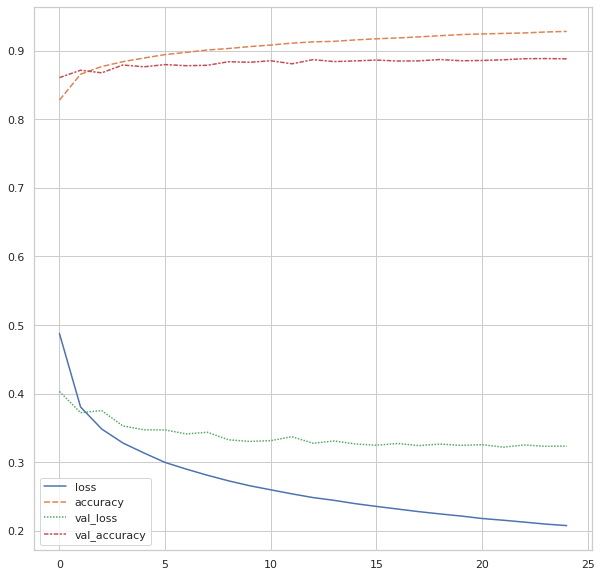

In [19]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics)

In [20]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 981us/step - loss: 0.7827 - accuracy: 0.7252


[0.782741904258728, 0.7251999974250793]

In [24]:
learning_rate = 0.01
n_epochs = 25
batch_size = 32
decay = 1e-4

In [23]:
epochs = np.arange(n_epochs)
n_batches_per_epoch = len(x_train) // batch_size

In [25]:
def lr(epoch):
    return learning_rate / (1 + (n_batches_per_epoch * epoch * decay))

<AxesSubplot:>

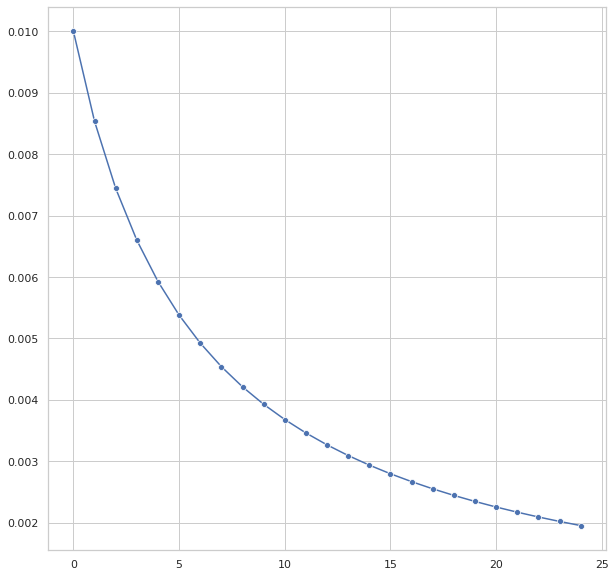

In [37]:
plt.figure(figsize = (10,10))
sns.lineplot(epochs, lr(epochs), marker = 'o')

## Exponential scheduling

- We will be writing a function which decreases the learning rate exponentially after s steps.
- We will then create a LearningRate callback and pass this function to it.

In [38]:
def lr_decay(lr0, s):
    def lr_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return lr_decay_fn

In [40]:
lr_decay_fn = lr_decay(lr0 = 0.01, s = 20)

In [48]:
keras.backend.clear_session()

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [50]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Nadam(lr = 0.01), metrics = ['accuracy'])

In [51]:
lr_callback = keras.callbacks.LearningRateScheduler(lr_decay_fn)

In [52]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8370 - accuracy: 0.7598 - val_loss: 0.9437 - val_accuracy: 0.7488
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7150 - accuracy: 0.7913 - val_loss: 0.6565 - val_accuracy: 0.8262
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5848 - accuracy: 0.8211 - val_loss: 0.7499 - val_accuracy: 0.7958
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5718 - accuracy: 0.8233 - val_loss: 0.5784 - val_accuracy: 0.8502
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4855 - accuracy: 0.8483 - val_loss: 0.5003 - val_accuracy: 0.8564
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4469 - accuracy: 0.8600 - val_loss: 0.4612 - val_accuracy: 0.8542
Epoch 7/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3980 - accuracy: 0.8698 - val_loss: 0.5421 - val_accuracy:

In [53]:
df_metrics = pd.DataFrame(history.history)

In [54]:
df_metrics.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.837033,0.759800,0.943750,0.7488,0.010000
1,0.714965,0.791291,0.656520,0.8262,0.008913
2,0.584752,0.821127,0.749893,0.7958,0.007943
3,0.571779,0.823291,0.578357,0.8502,0.007079
4,0.485504,0.848345,0.500334,0.8564,0.006310


<AxesSubplot:>

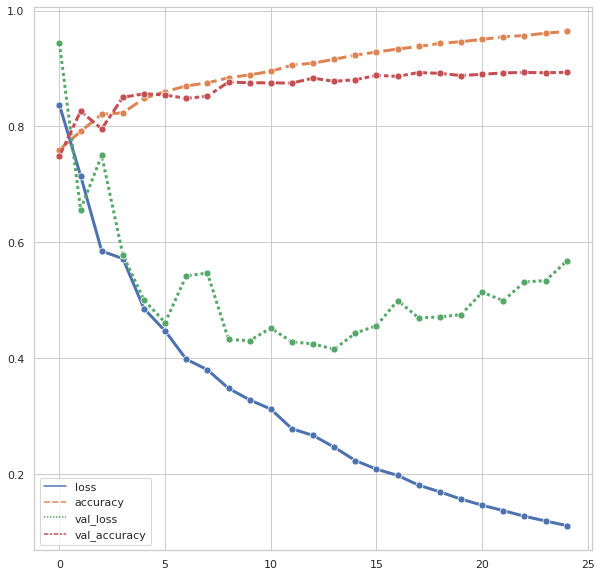

In [78]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics.drop(columns = 'lr'), marker = 'o', linewidth = 3, markersize = 7)

<AxesSubplot:>

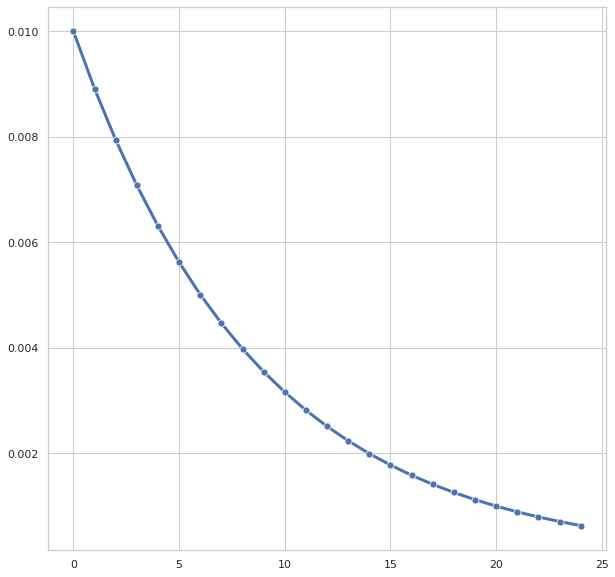

In [79]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics.lr, marker = 'o', linewidth = 3, markersize = 7)

- Now we will be updating the learning rate at each step instead of each epoch.

In [80]:
K = keras.backend

In [81]:
class lr_decay(keras.callbacks.Callback):
    def __init__(self, s = 40000):
        super().__init__()
        self.s = s
    def on_batch_end(self, batch, logs = None):
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1 ** (1 / s))
    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [82]:
keras.backend.clear_session()

In [84]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Nadam(lr = 0.01), metrics = ['accuracy'])

In [88]:
s = 20 * len(x_train) // 32

In [89]:
lr_callback = lr_decay(s)

In [90]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7916 - accuracy: 0.7670 - val_loss: 0.7207 - val_accuracy: 0.7752
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6354 - accuracy: 0.8037 - val_loss: 0.5067 - val_accuracy: 0.8350
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5528 - accuracy: 0.8267 - val_loss: 0.7006 - val_accuracy: 0.8066
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5034 - accuracy: 0.8423 - val_loss: 0.4801 - val_accuracy: 0.8516
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4677 - accuracy: 0.8541 - val_loss: 0.4463 - val_accuracy: 0.8596
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4275 - accuracy: 0.8647 - val_loss: 0.4617 - val_accuracy: 0.8620
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4129 - accuracy: 0.8694 - val_loss: 0.4348 - val_accuracy:

In [91]:
df_metrics = pd.DataFrame(history.history)

<AxesSubplot:>

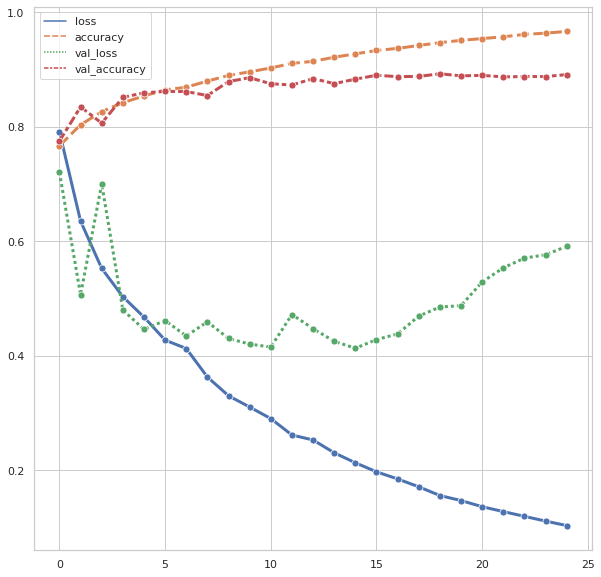

In [93]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = df_metrics.drop(columns = 'lr'), linewidth = 3, marker = 'o', markersize = 7)

<AxesSubplot:>

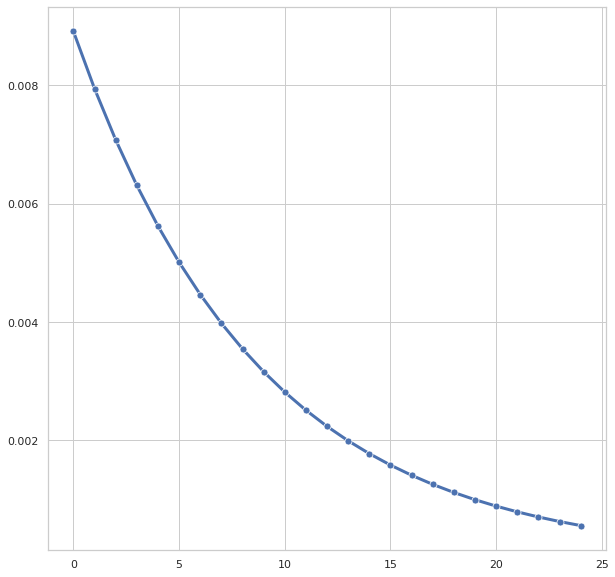

In [95]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = df_metrics.lr, linewidth = 3, marker = 'o', markersize = 7)

In [96]:
n_steps = 25 * len(x_train) // 32
steps = np.arange(n_steps)

In [97]:
def lr(steps, lr0):
    return lr0 * 0.1 ** (steps / s)

<AxesSubplot:>

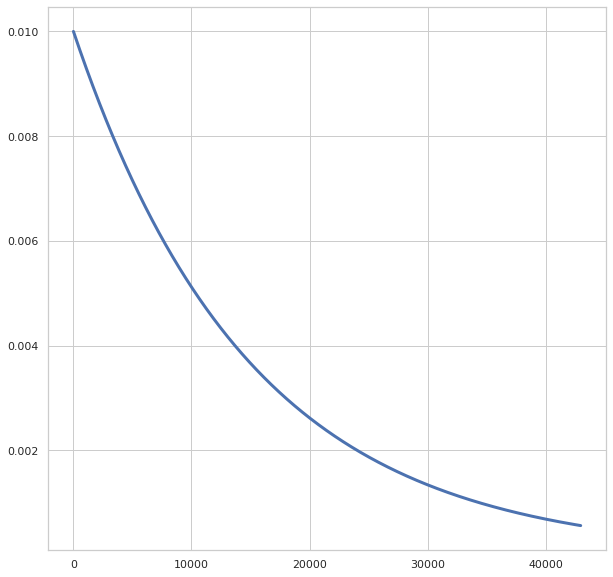

In [104]:
plt.figure(figsize = (10,10))
sns.lineplot(x = steps, y = lr(steps, 0.01), linewidth = 3)

## Piecewise constant scheduling